In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/GrowingNetwork/GroMo/misc

[Errno 2] No such file or directory: '/home/trudkiew/GrowingNetwork/GroMo/misc'
/home/trudkiew/Documents/GrowingNetwork/GroMo/misc


In [3]:
from gromo.growing_block import GrowingBlock, LinearGrowingBlock, LinearGrowingModule
from gromo.growing_mlp import GrowingMLP
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from auxilliary_functions import *

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [5]:
class IdDataloader:
    def __init__(self, nb_sample: int = 1, batch_size: int = 100, seed: int = 0, device=DEVICE):
        self.nb_sample = nb_sample
        self.batch_size = batch_size
        self.seed = seed
        self.sample_index = 0
        self.device = device
    
    def __iter__(self):
        torch.manual_seed(self.seed)
        self.sample_index = 0
        return self
    
    def __next__(self):
        if self.sample_index >= self.nb_sample:
            raise StopIteration
        self.sample_index += 1
        x = torch.rand(self.batch_size, 2, device=self.device)
        return x, x

In [6]:
def plt_model(model, fig):
    x = torch.linspace(0, 2 * np.pi, 1000, device=DEVICE).view(-1, 1)
    y = torch.sin(x)
    y_pred = model(x)
    fig.plot(x.cpu().numpy(), y.cpu().numpy(), label="sin")
    fig.plot(x.cpu().numpy(), y_pred.cpu().detach().numpy(), label="Predicted")
    for i in range(model[0].bias.data.shape[0]):
        split = -model[0].bias.data[i] / model[0].weight.data[i, 0]
        if 0 <= split <= 2 * np.pi:
            fig.axvline(split.item(), color="black", linestyle="--")
    fig.legend()
    fig.set_xlabel("x")
    fig.yaxis.set_label_position("right")
    fig.set_ylabel("sin(x)")

In [7]:
def plt_model_id(model, fig):
    x = torch.linspace(0, 1, 1000, device=DEVICE).view(-1, 1)
    # y = torch.selu(x)
    y = x
    y_pred = model(torch.cat([x, x], dim=1))
    fig.plot(x.cpu().numpy(), y.cpu().numpy(), label="selu")
    fig.plot(x.cpu().numpy(), y_pred[:, 0].cpu().detach().numpy(), label="Predicted 1")
    fig.plot(x.cpu().numpy(), y_pred[:, 1].cpu().detach().numpy(), label="Predicted 2")
    fig.legend()
    fig.set_xlabel("x")
    fig.yaxis.set_label_position("right")
    fig.set_ylabel("selu(x)")

# Hand crafted sin

In [33]:
n_neurons = 5
torch.manual_seed(0)
l1 = nn.Linear(1, n_neurons, device=DEVICE)
l2 = nn.Linear(n_neurons, 1, device=DEVICE)
net = nn.Sequential(l1, nn.ReLU(), l2)

In [34]:
batch_size = 1_000
nb_sample = 1_000

Initial error: 1.83e+00


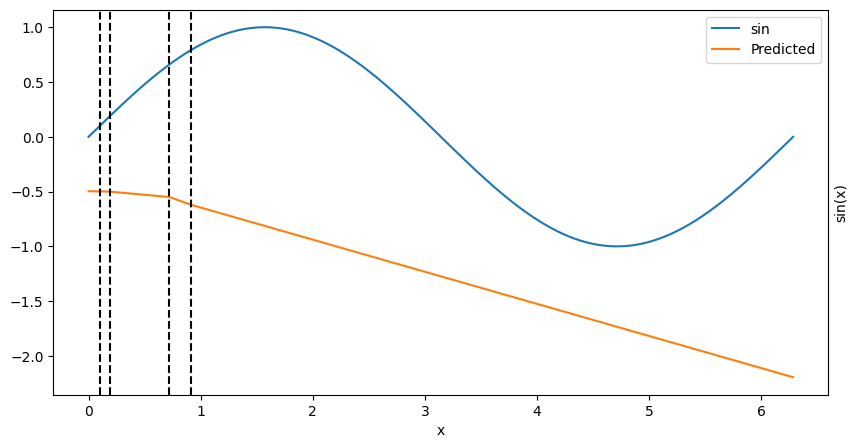

In [35]:
l2_err = evaluate_model(net, SinDataloader(nb_sample=nb_sample, batch_size=batch_size), AxisMSELoss())[0]
print(f"Initial error: {l2_err:.2e}")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt_model(net, ax)

In [36]:
l1.weight.data = torch.ones_like(l1.weight.data)
# a = np.pi / 4
# b = 1.
a = 1.1
b = 0.87
l1.bias.data = -torch.tensor([0, a, np.pi - a, np.pi + a , 2 * np.pi - a], device=DEVICE)
l2.weight.data = torch.tensor([[b, -b, -b, b, b]], device=DEVICE)
l2.bias.data = torch.tensor([0.], device=DEVICE)

In [37]:
"""
l1.weight.data = torch.ones_like(l1.weight.data)
# a = 1.1
# b = 0.87
cuts = torch.linspace(0, 2 * np.pi, n_neurons + 1, device=DEVICE)[:-1]
cuts_value = -torch.sin(cuts)
cuts_value[0] = 1
l1.bias.data = -cuts
l2.weight.data = cuts_value.view(1, -1)
l2.bias.data = torch.tensor([0.], device=DEVICE)

"""

'\nl1.weight.data = torch.ones_like(l1.weight.data)\n# a = 1.1\n# b = 0.87\ncuts = torch.linspace(0, 2 * np.pi, n_neurons + 1, device=DEVICE)[:-1]\ncuts_value = -torch.sin(cuts)\ncuts_value[0] = 1\nl1.bias.data = -cuts\nl2.weight.data = cuts_value.view(1, -1)\nl2.bias.data = torch.tensor([0.], device=DEVICE)\n\n'

Initial error: 1.08e-03


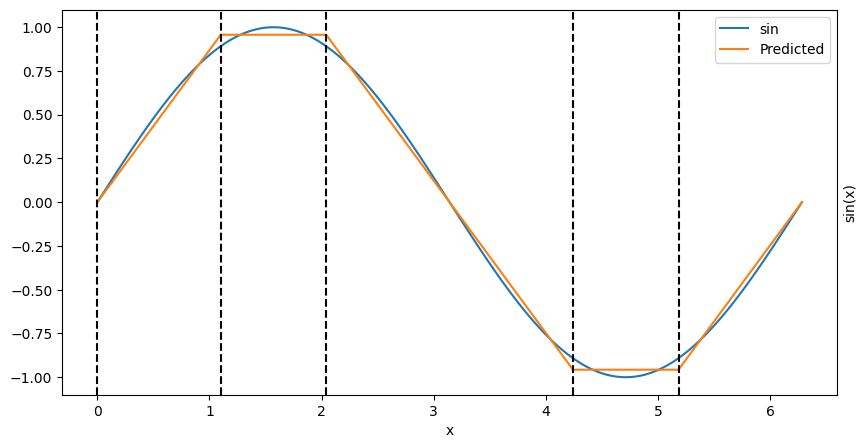

In [38]:
l2_err = evaluate_model(net, SinDataloader(nb_sample=nb_sample, batch_size=batch_size), AxisMSELoss())[0]
print(f"Initial error: {l2_err:.2e}")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt_model(net, ax)

In [39]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

res = train(net, 
            train_dataloader=SinDataloader(nb_sample=nb_sample, batch_size=batch_size), 
            optimizer=optimizer,
            nb_epoch=100, 
            show=True)
loss_train, accuracy_train, loss_val, accuracy_val = res
plt.plot(loss_train, label="train")
plt.plot(loss_val, label="val")
plt.legend()
plt.show()

plt.plot(accuracy_train, label="train")
plt.plot(accuracy_val, label="val")
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=8.520e-04, accuracy=0.00	 
Epoch 10:	 Train: loss=8.304e-04, accuracy=0.00	 
Epoch 20:	 Train: loss=8.304e-04, accuracy=0.00	 
Epoch 30:	 Train: loss=8.304e-04, accuracy=0.00	 
Epoch 40:	 Train: loss=8.304e-04, accuracy=0.00	 
Epoch 50:	 Train: loss=8.304e-04, accuracy=0.00	 


KeyboardInterrupt: 

Initial error: 8.27e-04


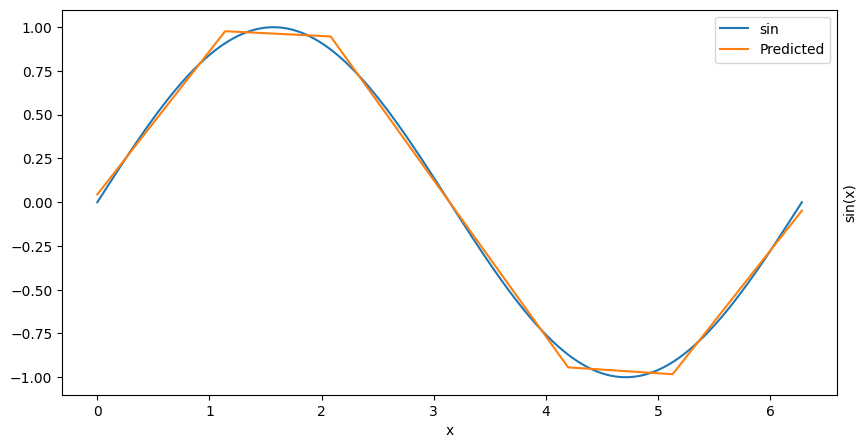

In [47]:
l2_err = evaluate_model(net, SinDataloader(nb_sample=nb_sample, batch_size=batch_size), AxisMSELoss())[0]
print(f"Initial error: {l2_err:.2e}")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt_model(net, ax)

Initial error: 8.26e-04


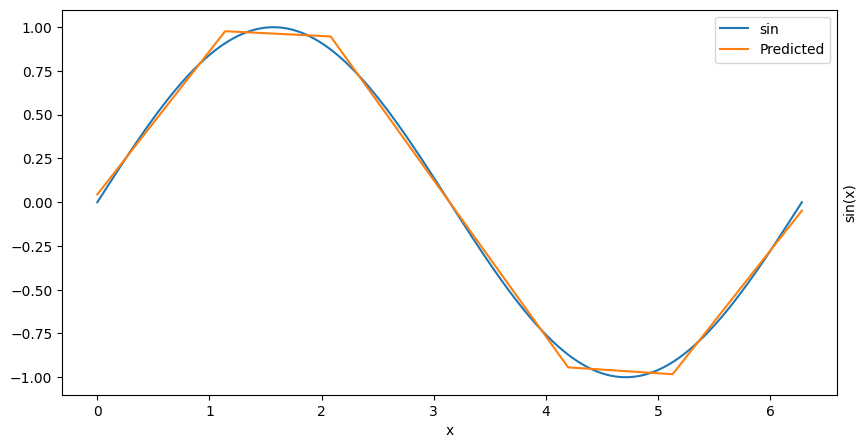

In [49]:
l2_err = evaluate_model(net, SinDataloader(nb_sample=nb_sample, batch_size=batch_size, seed=5), AxisMSELoss())[0]
print(f"Initial error: {l2_err:.2e}")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt_model(net, ax)

# Growing MLP

In [12]:
def plot():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt_model(model, ax)

In [55]:
loss_func_sum = AxisMSELoss(reduction="sum")
loss_func_mean = AxisMSELoss(reduction="mean")

TypeError: super(type, obj): obj must be an instance or subtype of type

In [56]:
def step(show=True, selected_layer=None, gamma_sample:int=100):

    train_dataloader = SinDataloader(nb_sample=nb_sample, batch_size=batch_size)
    
    initial_loss, _ = compute_statistics(growing_model=model, loss_function=loss_func_sum, dataloader=train_dataloader)
    print(f"Initial loss: {initial_loss:.3e}")
    
    model.compute_optimal_update(part='all', dtype=torch.float64)
    model.reset_computation()
    if selected_layer is None:
        model.select_best_update(verbose=show)
    else:
        model.select_update(selected_layer, verbose=show)
    # model.currently_updated_layer.delete_update()
    
    selected_gamma, estimated_loss, x_sup, y_sup = line_search(model=model,
                loss_function=loss_func_sum,
                dataloader=SinDataloader(nb_sample=nb_sample, batch_size=batch_size),
                initial_loss=initial_loss,
                first_order_improvement=model.updates_values[model.currently_updated_layer_index],
                verbose=show)
    x_sup = np.array(x_sup)
    y_sup = np.array(y_sup)
    print(f"Selected gamma: {selected_gamma:.3e}, new loss: {estimated_loss:.3e}")
    print(f"Improvement: {initial_loss - estimated_loss:.3e}, fo improvement: {selected_gamma * model.currently_updated_layer.first_order_improvement.item():.3e}")
    
    if show:
        window = min(5 * selected_gamma, 2 * max(x_sup))
        x, y = full_search(model=model,
                    loss=loss_func_sum,
                    dataloader=SinDataloader(nb_sample=nb_sample, batch_size=batch_size),
                    initial_loss=None,
                    first_order_improvement=model.updates_values[model.currently_updated_layer_index],
                    min_value=-window,
                    max_value=window,
                    nb_points=gamma_sample)
    
    model.amplitude_factor = np.sqrt(selected_gamma)
    model.apply_update()
    
    if show:
        x_min = x[np.argmin(y)]
        plt.axvline(x_min, color="red", label=f"Minimum {x_min:.3e}")
        plt.plot(x, y)
        plt.plot(x, -x * model.currently_updated_layer.first_order_improvement.item() + initial_loss, label=f"First order improvement {model.currently_updated_layer.first_order_improvement.item():.3e}")
        selected_sup = x_sup < window
        plt.scatter(0, initial_loss, color="blue", label="Initial loss")
        plt.scatter(x_sup[selected_sup], y_sup[selected_sup], color="green", label="Line search", marker="x")
        plt.scatter(selected_gamma, estimated_loss, color="red", label="Selected gamma")
        plt.ylim(0, 1.1 * max(y))
        plt.legend()
    
    # model.currently_updated_layer.delete_update()

In [57]:
def info():
    loss, _ = evaluate_model(model=model, loss_function=loss_func_mean, dataloader=SinDataloader(nb_sample=nb_sample, batch_size=batch_size))
    print(f"Loss: {loss:.3e}")
    plot()
    for lay in model.layers:
        print(lay)
        # print(lay.weight)
        print(f"Min: {lay.weight.min().item()}, Max: {lay.weight.max().item()}")
    return model

In [58]:
batch_size = 1_000
nb_sample = 100

model = GrowingMLP(1, 1, 10, 2, activation=nn.SELU(), bias=True)
# model = GrowingMLP(1, 1, 100, 2, activation=nn.ReLU(), bias=True)
model

LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=10, out_features=1, use_bias=True)

Loss: 7.931e-01
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
Min: -0.6650068163871765, Max: 0.9635912179946899
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=10, use_bias=True)
Min: -0.313663512468338, Max: 0.29451265931129456
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=10, out_features=1, use_bias=True)
Min: -0.23954647779464722, Max: 0.31351080536842346


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=10, out_features=1, use_bias=True)

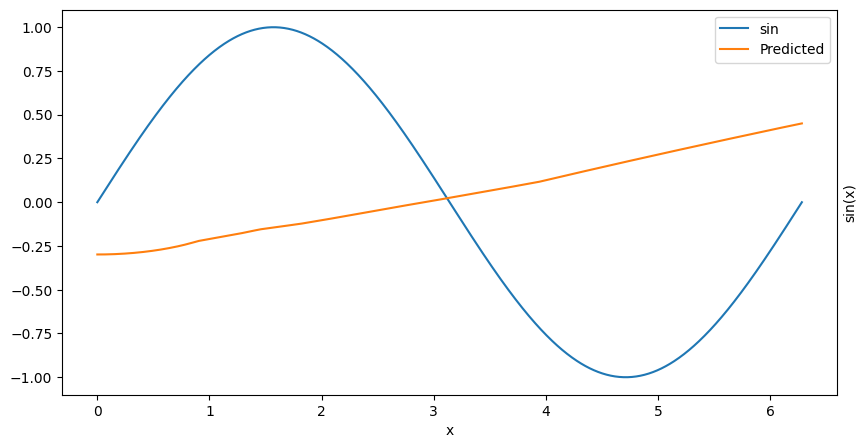

In [59]:
info()

Initial loss: 7.931e-01
Layer 0 update: 0.20520028277966856
Layer 0 parameter improvement: 0.20520028277966856
Layer 0 eigenvalues extension: None
Deleting layer 0
Layer 1 update: 4.060617519345584
Layer 1 parameter improvement: 0.9793954620030547
Layer 1 eigenvalues extension: tensor([1.7021, 0.1877], device='cuda:0')
Deleting layer 1
Layer 2 update: 16.443301461925007
Layer 2 parameter improvement: 3.1708023774523504
Layer 2 eigenvalues extension: tensor([3.5542], device='cuda:0')
Out extension: layer.extended_input_layer.weight=Parameter containing:
tensor([[1.8852]], device='cuda:0', requires_grad=True) layer.extended_input_layer.bias=Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True)
gamma n° 1: 4.823e-02 -> Loss: 3.529e-01
gamma n° 2: 9.647e-02 -> Loss: 1.038e-01
gamma n° 3: 1.929e-01 -> Loss: 5.030e-02
gamma n° 4: 3.859e-01 -> Loss: 1.422e+00
Selected gamma: 1.929e-01, new loss: 5.030e-02
Improvement: 7.428e-01, fo improvement: 3.172e+00


  0%|          | 0/100 [00:00<?, ?it/s]

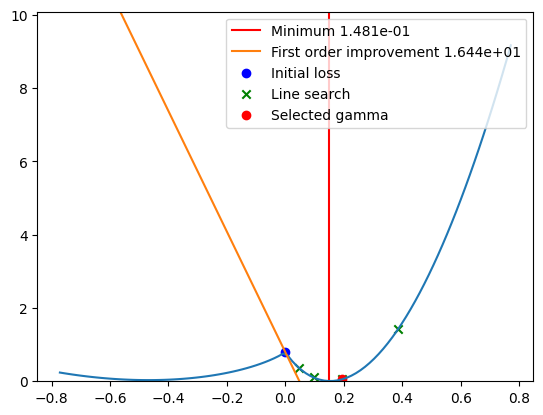

In [60]:
step(gamma_sample=100)

Loss: 5.030e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
Min: -0.6650068163871765, Max: 0.9635912179946899
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
Min: -65.55571746826172, Max: 65.7522201538086
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)
Min: -12.857858657836914, Max: 8.148877143859863


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)

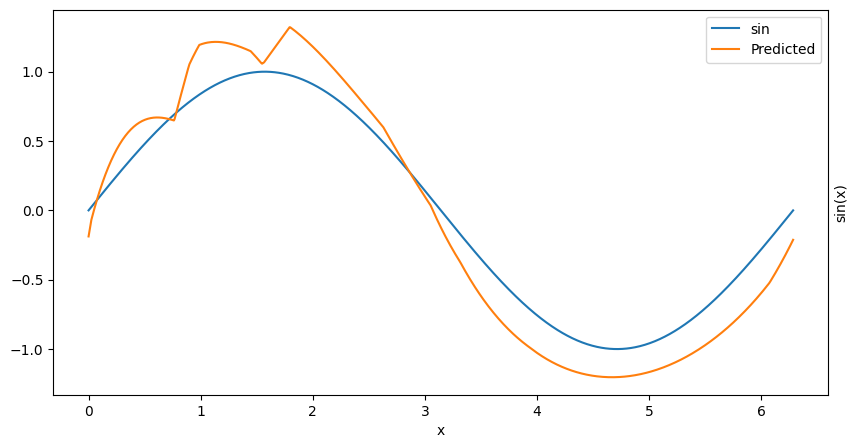

In [61]:
info()

Initial loss: 5.030e-02
Layer 0 update: 809.0591523095206
Layer 0 parameter improvement: 809.0591523095206
Layer 0 eigenvalues extension: None
Layer 1 update: 341.75923875237004
Layer 1 parameter improvement: 80.65996507072941
Layer 1 eigenvalues extension: tensor([15.6870,  1.5554], device='cuda:0')
Deleting layer 1
Layer 2 update: 0.9575626967516975
Layer 2 parameter improvement: 0.19808680992995065
Layer 2 eigenvalues extension: tensor([0.8502], device='cuda:0')
Deleting layer 2
gamma n° 1: 6.217e-05 -> Loss: 2.466e-02
gamma n° 2: 1.243e-04 -> Loss: 5.453e-02
Selected gamma: 6.217e-05, new loss: 2.466e-02
Improvement: 2.564e-02, fo improvement: 5.030e-02


  0%|          | 0/100 [00:00<?, ?it/s]

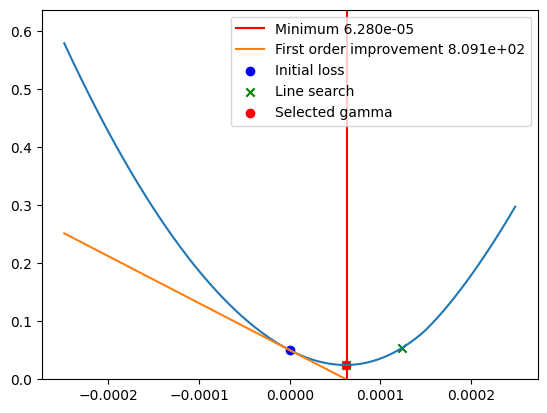

In [62]:
step()

Loss: 2.466e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
Min: -0.665148138999939, Max: 0.9636053442955017
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
Min: -65.55571746826172, Max: 65.7522201538086
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)
Min: -12.857858657836914, Max: 8.148877143859863


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)

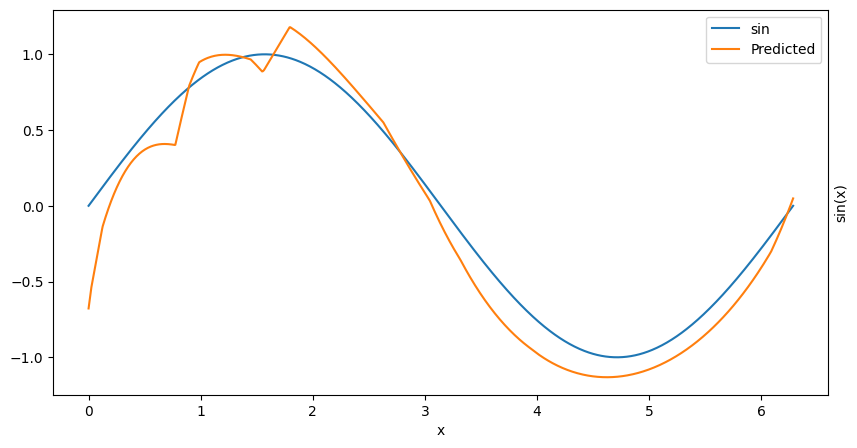

In [63]:
info()

In [ ]:
model.normalise()

In [ ]:
info()

Initial loss: 2.466e-02
Layer 0 update: 243.78517858670602
Layer 0 parameter improvement: 243.78517858670602
Layer 0 eigenvalues extension: None
Layer 1 update: 99.78774127376346
Layer 1 parameter improvement: 38.368155092122834
Layer 1 eigenvalues extension: tensor([7.5940, 0.8870], device='cuda:0')
Deleting layer 1
Layer 2 update: 0.44209654450685165
Layer 2 parameter improvement: 0.09448949814111374
Layer 2 eigenvalues extension: tensor([0.5752], device='cuda:0')
Deleting layer 2
gamma n° 1: 1.011e-04 -> Loss: 2.089e-02
gamma n° 2: 2.023e-04 -> Loss: 6.104e-02
Selected gamma: 1.011e-04, new loss: 2.089e-02
Improvement: 3.772e-03, fo improvement: 2.466e-02


  0%|          | 0/100 [00:00<?, ?it/s]

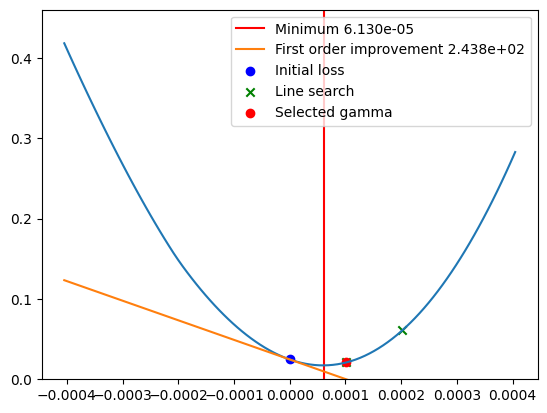

In [64]:
step()

Loss: 2.089e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
Min: -0.6649545431137085, Max: 0.9636039137840271
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
Min: -65.55571746826172, Max: 65.7522201538086
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)
Min: -12.857858657836914, Max: 8.148877143859863


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)

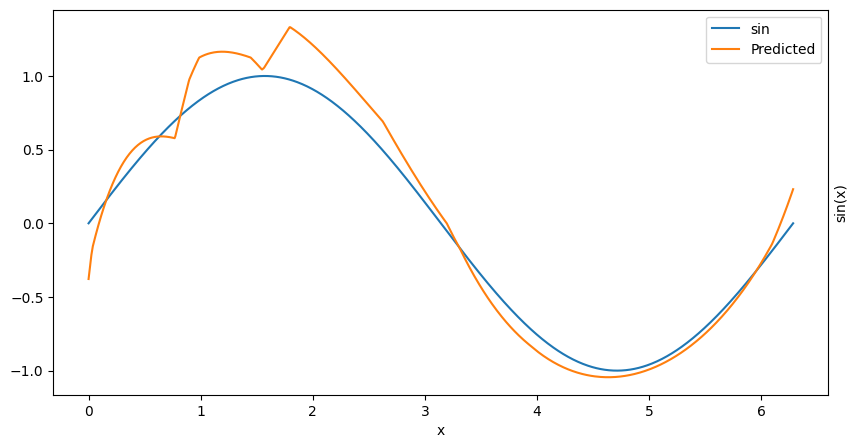

In [65]:
info()

Initial loss: 2.089e-02
Layer 0 update: 276.3455914102504
Layer 0 parameter improvement: 276.3455914102504
Layer 0 eigenvalues extension: None
Layer 1 update: 102.61190217152358
Layer 1 parameter improvement: 39.09301179066421
Layer 1 eigenvalues extension: tensor([7.7697, 0.2919], device='cuda:0')
Deleting layer 1
Layer 2 update: 0.3840106485576138
Layer 2 parameter improvement: 0.07998771054453702
Layer 2 eigenvalues extension: tensor([0.5379], device='cuda:0')
Deleting layer 2
gamma n° 1: 7.558e-05 -> Loss: 1.896e-02
gamma n° 2: 3.779e-05 -> Loss: 1.516e-02
gamma n° 3: 1.889e-05 -> Loss: 1.684e-02
Selected gamma: 3.779e-05, new loss: 1.516e-02
Improvement: 5.729e-03, fo improvement: 1.044e-02


  0%|          | 0/100 [00:00<?, ?it/s]

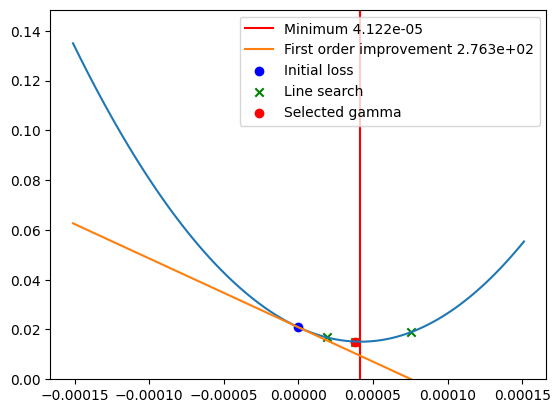

In [66]:
step()

Loss: 1.516e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
Min: -0.6649919748306274, Max: 0.9636069536209106
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
Min: -65.55571746826172, Max: 65.7522201538086
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)
Min: -12.857858657836914, Max: 8.148877143859863


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)

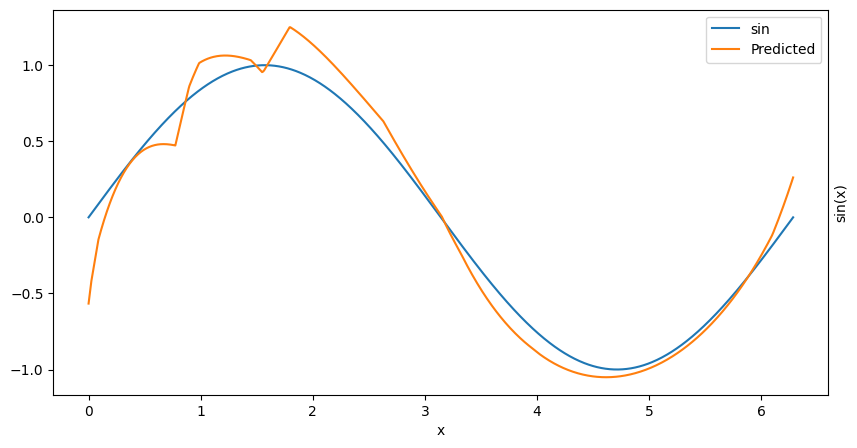

In [67]:
info()

model.normalise()

Loss: 1.896e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
Min: -0.6650294661521912, Max: 0.9636099934577942
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
Min: -65.55571746826172, Max: 65.7522201538086
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)
Min: -12.857858657836914, Max: 8.148877143859863


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)

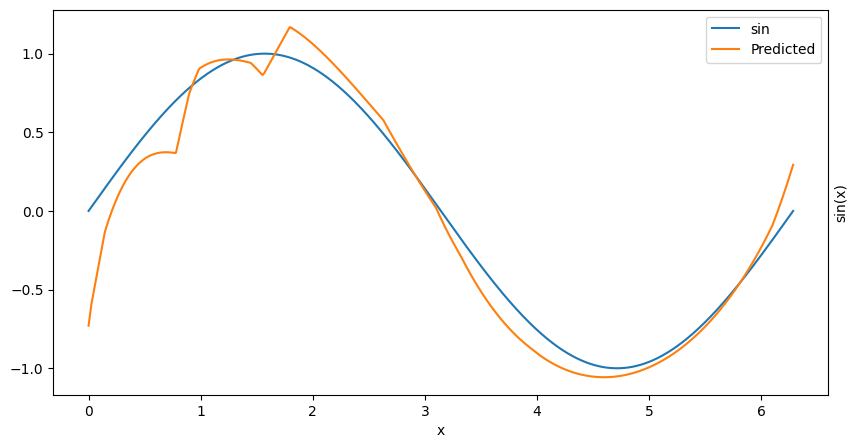

In [49]:
info()

In [68]:
torch.save(model, "model.pt")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=2.624e-01, accuracy=0.00	 
Epoch 2:	 Train: loss=2.381e-02, accuracy=0.00	 
Epoch 4:	 Train: loss=1.729e-02, accuracy=0.00	 
Epoch 6:	 Train: loss=1.498e-02, accuracy=0.00	 
Epoch 8:	 Train: loss=1.378e-02, accuracy=0.00	 
Epoch 10:	 Train: loss=1.295e-02, accuracy=0.00	 
Epoch 12:	 Train: loss=1.228e-02, accuracy=0.00	 
Epoch 14:	 Train: loss=1.168e-02, accuracy=0.00	 
Epoch 16:	 Train: loss=1.113e-02, accuracy=0.00	 
Epoch 18:	 Train: loss=1.062e-02, accuracy=0.00	 


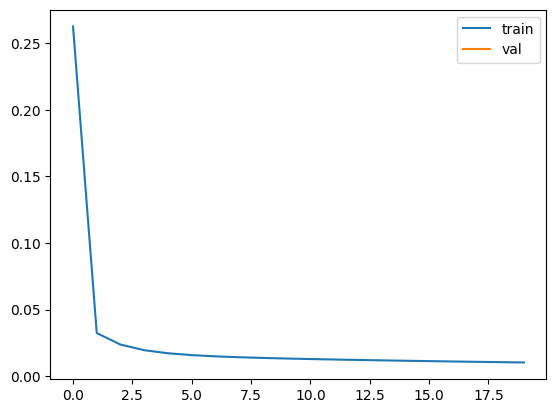

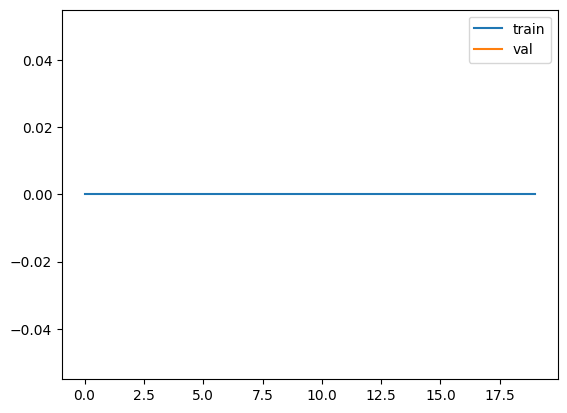

In [69]:
res = train(model, 
            train_dataloader=SinDataloader(nb_sample=nb_sample, batch_size=batch_size), 
            optimizer=torch.optim.SGD(model.parameters(), lr=1e-4),
            nb_epoch=20, 
            show=True)
loss_train, accuracy_train, loss_val, accuracy_val = res
plt.plot(loss_train, label="train")
plt.plot(loss_val, label="val")
plt.legend()
plt.show()

plt.plot(accuracy_train, label="train")
plt.plot(accuracy_val, label="val")
plt.legend()
plt.show()

Loss: 1.023e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
Min: -0.6625962257385254, Max: 0.9694522619247437
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
Min: -65.55587005615234, Max: 65.75251770019531
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)
Min: -12.858067512512207, Max: 8.149211883544922


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=11, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=11, out_features=1, use_bias=True)

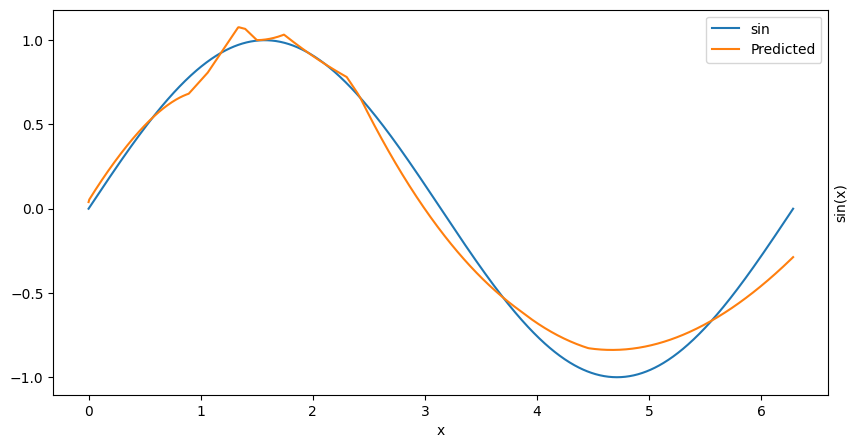

In [70]:
info()

In [71]:
model.weights_statistics()

{0: {'weight': {'min': -0.6625962257385254,
   'max': 0.9694522619247437,
   'mean': 0.0625191256403923,
   'std': 0.46726828813552856},
  'bias': {'min': -0.8662030100822449,
   'max': 0.1698719710111618,
   'mean': -0.2783244550228119,
   'std': 0.3755960166454315},
  'input_shape': 1,
  'output_shape': 10},
 1: {'weight': {'min': -65.55587005615234,
   'max': 65.75251770019531,
   'mean': -0.4792197346687317,
   'std': 12.228632926940918},
  'bias': {'min': -0.22922880947589874,
   'max': 53.50847244262695,
   'mean': 4.891878604888916,
   'std': 16.12542724609375},
  'input_shape': 10,
  'output_shape': 11},
 2: {'weight': {'min': -12.858067512512207,
   'max': 8.149211883544922,
   'mean': 1.1879138946533203,
   'std': 5.674689769744873},
  'bias': {'min': -2.2461721897125244,
   'max': -2.2461721897125244,
   'mean': -2.2461721897125244,
   'std': -1},
  'input_shape': 11,
  'output_shape': 1}}

# Only adding neurons

In [28]:
def plot():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt_model_id(model, ax)

In [35]:
loss_func_sum = AxisMSELoss(reduction="sum")
loss_func_mean = AxisMSELoss(reduction="mean")

In [47]:
def step(show=True, selected_layer=None):
    train_dataloader = IdDataloader(nb_sample=nb_sample, batch_size=batch_size)

    initial_loss, _ = compute_statistics(growing_model=model,
                                        loss_function=loss_func_sum, 
                                        dataloader=train_dataloader)
    
    print(f"Initial loss: {initial_loss:.3e}")
    
    model.compute_optimal_update(part='neuron')
    model.reset_computation()
    if selected_layer is None:
        model.select_best_update(verbose=show)
    else:
        model.select_update(selected_layer, verbose=show)
    # model.currently_updated_layer.delete_update()
    
    selected_gamma, estimated_loss, x_sup, y_sup = line_search(model=model,
                loss_function=loss_func_sum,
                dataloader=IdDataloader(nb_sample=nb_sample, batch_size=batch_size),
                initial_loss=initial_loss,
                first_order_improvement=model.updates_values[model.currently_updated_layer_index],
                verbose=show)
    x_sup = np.array(x_sup)
    y_sup = np.array(y_sup)
    print(f"Selected gamma: {selected_gamma:.3e}, new loss: {estimated_loss:.3e}")
    print(f"Improvement: {initial_loss - estimated_loss:.3e}, fo improvement: {selected_gamma * model.currently_updated_layer.first_order_improvement.item():.3e}")
    
    if show:
        window = 5 * selected_gamma
        x, y = full_search(model=model,
                    loss=loss_func_sum,
                    dataloader=IdDataloader(nb_sample=nb_sample, batch_size=batch_size),
                    initial_loss=None,
                    first_order_improvement=model.updates_values[model.currently_updated_layer_index],
                    min_value=-window,
                    max_value=window)
    
    model.amplitude_factor = np.sqrt(selected_gamma)
    model.apply_update()
    
    if show:
        x_min = x[np.argmin(y)]
        plt.axvline(x_min, color="red", label=f"Minimum {x_min:.3e}")
        plt.plot(x, y)
        plt.plot(x, -x * model.currently_updated_layer.first_order_improvement.item() + initial_loss, label=f"First order improvement {model.currently_updated_layer.first_order_improvement.item():.3e}")
        selected_sup = x_sup < window
        plt.scatter(x_sup[selected_sup], y_sup[selected_sup], color="green", label="Line search", marker="x")
        plt.scatter(selected_gamma, estimated_loss, color="red", label="Selected gamma")
        plt.ylim(0, 1.1 * max(y))
        plt.legend()
    
    # model.currently_updated_layer.delete_update()

In [48]:
def info():
    loss, _ = evaluate_model(model=model, loss_function=loss_func_mean, dataloader=IdDataloader(nb_sample=nb_sample, batch_size=batch_size))
    print(f"Loss: {loss:.3e}")
    plot()
    for lay in model.layers:
        print(lay)
        # print(lay.weight)
        print(f"Min: {lay.weight.min().item()}, Max: {lay.weight.max().item()}")
    return model

In [49]:
batch_size = 1_000
nb_sample = 100

model = GrowingMLP(2, 2, 2, 1, activation=nn.ReLU(), bias=False)
model

LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=2, use_bias=False)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=2, out_features=2, use_bias=False)

In [50]:
model.layers[0].weight = nn.Parameter(torch.tensor([[1., 0.], [0., 1.]], device=DEVICE))
model.layers[1].weight = nn.Parameter(torch.tensor([[1., 0.], [0., 1.]], device=DEVICE))

Loss: 0.000e+00
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=2, use_bias=False)
Min: 0.0, Max: 1.0
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=2, out_features=2, use_bias=False)
Min: 0.0, Max: 1.0


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=2, use_bias=False)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=2, out_features=2, use_bias=False)

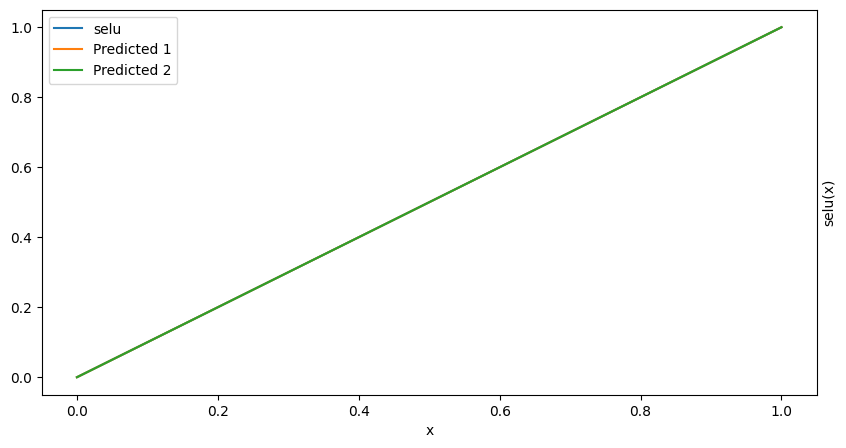

In [51]:
info()

In [52]:
batch_size = 1_000
nb_sample = 100

model = GrowingMLP(2, 2, 1, 1, activation=nn.ReLU(), bias=False)
model

LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=1, use_bias=False)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=1, out_features=2, use_bias=False)

In [53]:
model.layers[0].weight = nn.Parameter(torch.tensor([[1., 0.]], device=DEVICE))
model.layers[1].weight = nn.Parameter(torch.tensor([[1.], [0.]], device=DEVICE))

Loss: 3.328e-01
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=1, use_bias=False)
Min: 0.0, Max: 1.0
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=1, out_features=2, use_bias=False)
Min: 0.0, Max: 1.0


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=1, use_bias=False)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=1, out_features=2, use_bias=False)

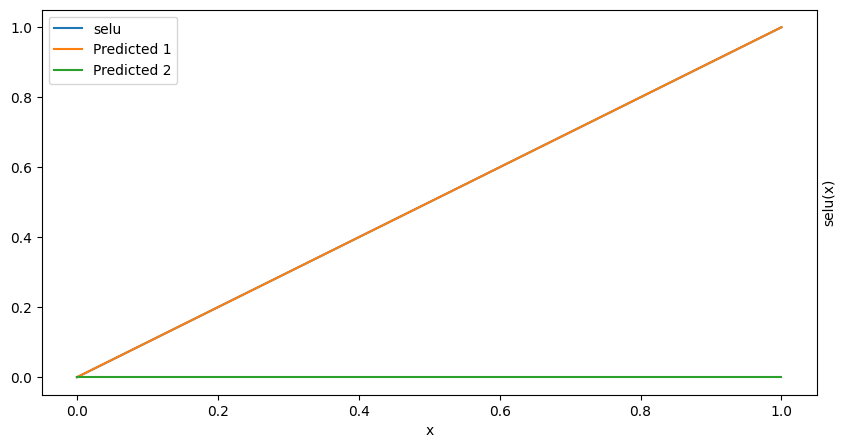

In [54]:
info()

Initial loss: 3.328e-01
Layer 0 update: 0
Layer 0 parameter improvement: 0
Layer 0 eigenvalues extension: None
Deleting layer 0
Layer 1 update: 1.3312740325927734
Layer 1 parameter improvement: 0
Layer 1 eigenvalues extension: tensor([1.1538], device='cuda:0')
Out extension: layer.extended_input_layer.weight=Parameter containing:
tensor([[0.0000],
        [1.0742]], device='cuda:0', requires_grad=True) layer.extended_input_layer.bias=None
gamma: 2.500e-01 -> Loss: 8.320e-02
Selected gamma: 2.500e-01, new loss: 8.320e-02
Improvement: 2.496e-01, fo improvement: 3.328e-01


  0%|          | 0/100 [00:00<?, ?it/s]

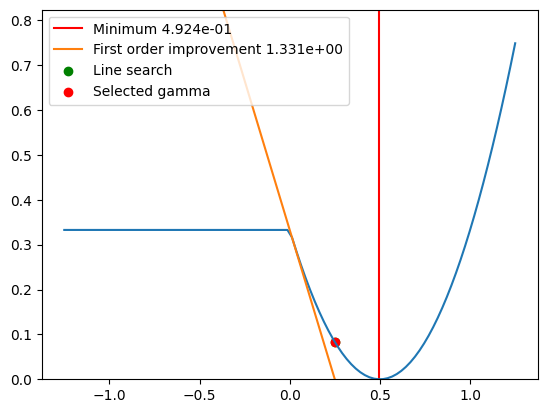

In [55]:
step()

Loss: 8.320e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=2, use_bias=False)
Min: -1.92073827065542e-07, Max: 1.0
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=2, out_features=2, use_bias=False)
Min: 0.0, Max: 1.0


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=2, use_bias=False)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=2, out_features=2, use_bias=False)

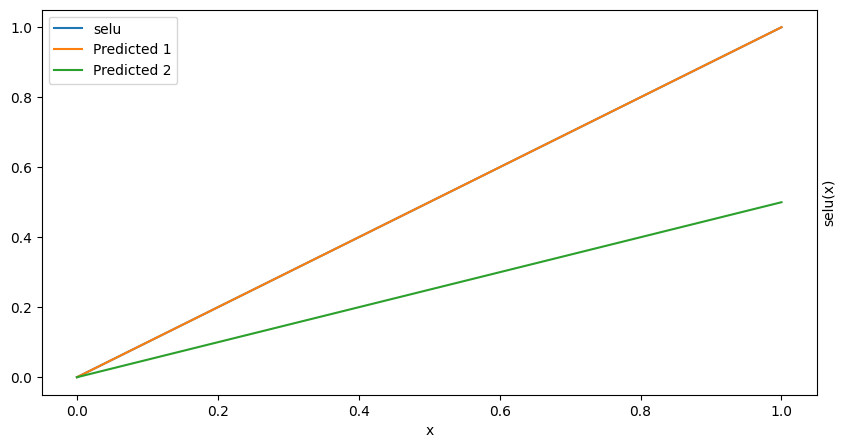

In [56]:
info()

Initial loss: 8.320e-02
Layer 0 update: 0
Layer 0 parameter improvement: 0
Layer 0 eigenvalues extension: None
Deleting layer 0
Layer 1 update: 0.33281850814819336
Layer 1 parameter improvement: 0
Layer 1 eigenvalues extension: tensor([0.5769], device='cuda:0')
Out extension: layer.extended_input_layer.weight=Parameter containing:
tensor([[0.0000],
        [0.7595]], device='cuda:0', requires_grad=True) layer.extended_input_layer.bias=None
gamma: 2.500e-01 -> Loss: 2.080e-02
Selected gamma: 2.500e-01, new loss: 2.080e-02
Improvement: 6.240e-02, fo improvement: 8.320e-02


  0%|          | 0/100 [00:00<?, ?it/s]

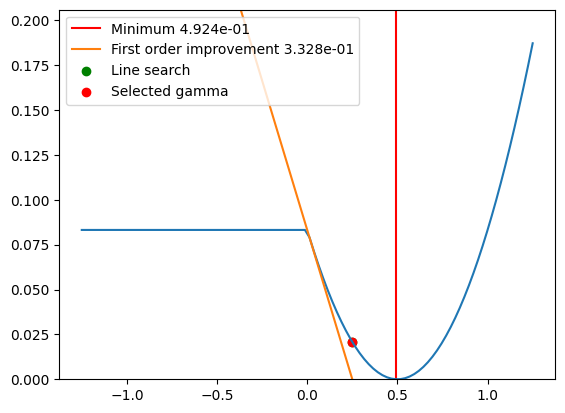

In [57]:
step()

Loss: 2.080e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=3, use_bias=False)
Min: -1.92073827065542e-07, Max: 1.0
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=3, out_features=2, use_bias=False)
Min: 0.0, Max: 1.0


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=3, use_bias=False)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=3, out_features=2, use_bias=False)

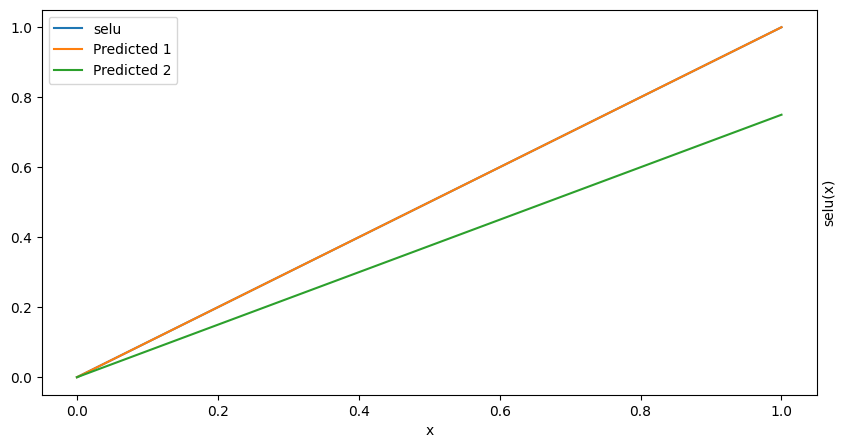

In [58]:
info()

Initial loss: 2.080e-02
Layer 0 update: 0
Layer 0 parameter improvement: 0
Layer 0 eigenvalues extension: None
Deleting layer 0
Layer 1 update: 0.08320462703704834
Layer 1 parameter improvement: 0
Layer 1 eigenvalues extension: tensor([0.2885], device='cuda:0')
Out extension: layer.extended_input_layer.weight=Parameter containing:
tensor([[0.0000],
        [0.5371]], device='cuda:0', requires_grad=True) layer.extended_input_layer.bias=None
gamma: 2.500e-01 -> Loss: 5.200e-03
Selected gamma: 2.500e-01, new loss: 5.200e-03
Improvement: 1.560e-02, fo improvement: 2.080e-02


  0%|          | 0/100 [00:00<?, ?it/s]

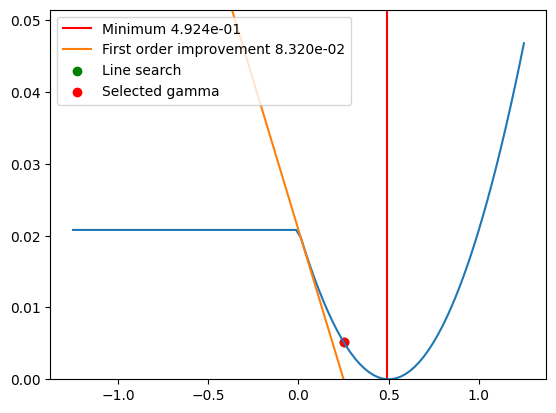

In [59]:
step()

Loss: 5.200e-03
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=4, use_bias=False)
Min: -1.92073827065542e-07, Max: 1.0
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=4, out_features=2, use_bias=False)
Min: 0.0, Max: 1.0


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=2, out_features=4, use_bias=False)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=4, out_features=2, use_bias=False)

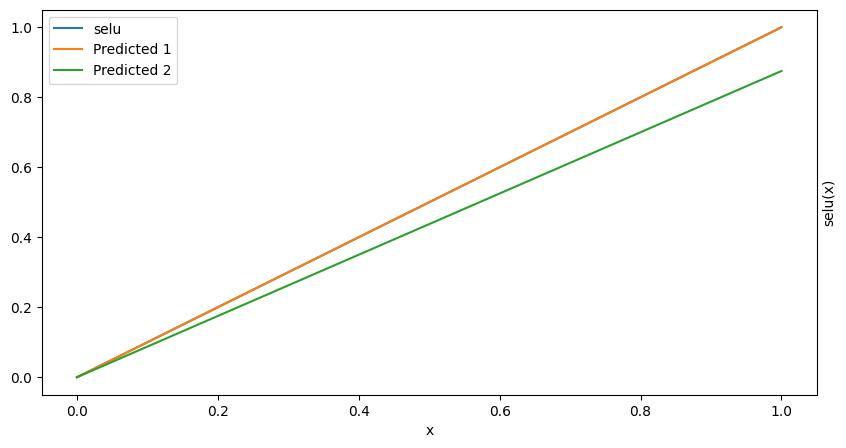

In [60]:
info()

# Fixed size, natural gradient

In [8]:
def plot():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt_model(model, ax)

In [9]:
def step(show=True, selected_layer=None):

    train_dataloader = SinDataloader(nb_sample=nb_sample, batch_size=batch_size)
    initial_loss, _ = compute_statistics(growing_model=model, 
                                         loss_function=AxisMSELoss(reduction="sum"),
                                         dataloader=train_dataloader)

    print(f"Initial loss: {initial_loss:.3e}")
    
    model.compute_optimal_update(part='parameter')
    model.reset_computation()
    if selected_layer is None:
        model.select_best_update(verbose=show)
    else:
        model.select_update(selected_layer, verbose=show)
    # model.currently_updated_layer.delete_update()

    selected_gamma, estimated_loss, x_sup, y_sup = line_search(model=model,
                                                               loss_function=loss_func_sum,
                                                               dataloader=IdDataloader(nb_sample=nb_sample,
                                                                                       batch_size=batch_size),
                                                               initial_loss=initial_loss,
                                                               first_order_improvement=model.updates_values[
                                                                   model.currently_updated_layer_index],
                                                               verbose=show)
    x_sup = np.array(x_sup)
    y_sup = np.array(y_sup)
    print(f"Selected gamma: {selected_gamma:.3e}, new loss: {estimated_loss:.3e}")
    print(
        f"Improvement: {initial_loss - estimated_loss:.3e}, fo improvement: {selected_gamma * model.currently_updated_layer.first_order_improvement.item():.3e}")

    if show:
        window = 5 * selected_gamma
        x, y = full_search(model=model,
                           loss=loss_func_sum,
                           dataloader=IdDataloader(nb_sample=nb_sample, batch_size=batch_size),
                           initial_loss=None,
                           first_order_improvement=model.updates_values[model.currently_updated_layer_index],
                           min_value=-window,
                           max_value=window)

    model.amplitude_factor = np.sqrt(selected_gamma)
    model.apply_update()

    if show:
        x_min = x[np.argmin(y)]
        plt.axvline(x_min, color="red", label=f"Minimum {x_min:.3e}")
        plt.plot(x, y)
        plt.plot(x, -x * model.currently_updated_layer.first_order_improvement.item() + initial_loss,
                 label=f"First order improvement {model.currently_updated_layer.first_order_improvement.item():.3e}")
        selected_sup = x_sup < window
        plt.scatter(x_sup[selected_sup], y_sup[selected_sup], color="green", label="Line search", marker="x")
        plt.scatter(selected_gamma, estimated_loss, color="red", label="Selected gamma")
        plt.ylim(0, 1.1 * max(y))
        plt.legend()

    # model.currently_updated_layer.delete_update()

In [10]:
def info():
    loss, _ = evaluate_model(model=model, loss_function=nn.MSELoss(reduction="mean"), dataloader=SinDataloader(nb_sample=nb_sample, batch_size=batch_size))
    print(f"Loss: {loss:.3e}")
    plot()
    for lay in model.layers:
        print(lay)
        # print(lay.weight)
        print(f"Min: {lay.weight.min().item()}, Max: {lay.weight.max().item()}")
    return model

In [11]:
batch_size = 1_000
nb_sample = 100
model = GrowingMLP(1, 1, 5, 1, activation=nn.SELU())
model

LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)

Loss: 1.374e+00
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
Min: -0.5791729092597961, Max: 0.4794309139251709
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)
Min: -0.21282164752483368, Max: 0.4418494999408722


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)

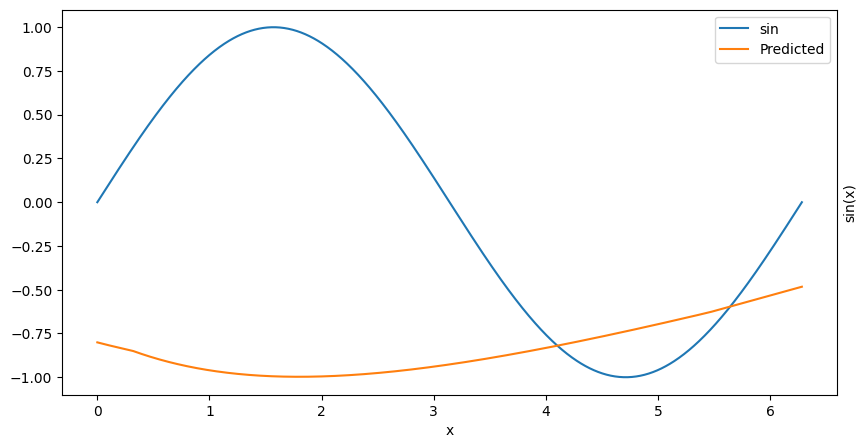

In [12]:
info()

Initial loss: 1.374e+00
Layer 0 update: 1.0169214010238647
Layer 0 parameter improvement: 1.0169214010238647
Layer 0 eigenvalues extension: None
Deleting layer 0
Layer 1 update: 5.4409637451171875
Layer 1 parameter improvement: 5.4409637451171875
Layer 1 eigenvalues extension: None
gamma: 2.525e-01 -> Loss: 3.472e-01
Selected gamma: 2.525e-01, new loss: 3.472e-01
Improvement: 1.027e+00, fo improvement: 1.374e+00


  0%|          | 0/100 [00:00<?, ?it/s]

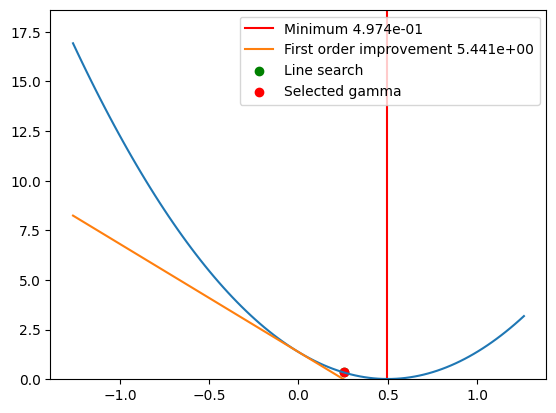

In [13]:
step()

Loss: 3.472e-01
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
Min: -0.5791729092597961, Max: 0.4794309139251709
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)
Min: -14.992019653320312, Max: 56.301029205322266


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)

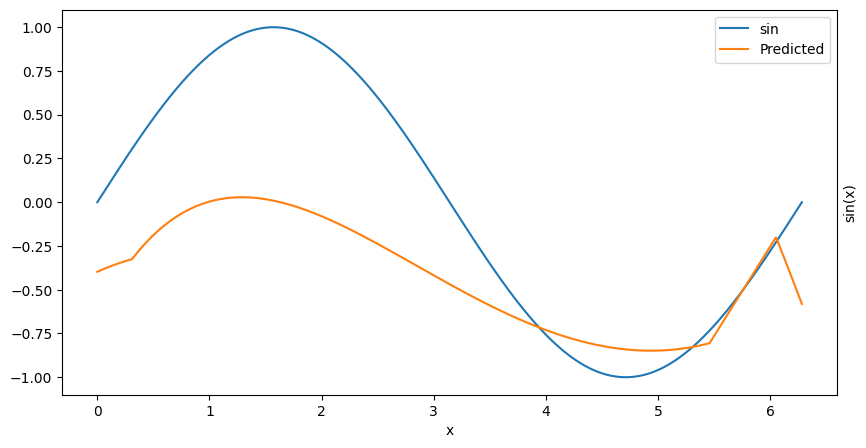

In [14]:
info()

Initial loss: 3.472e-01
Layer 0 update: 6394.11328125
Layer 0 parameter improvement: 6394.11328125
Layer 0 eigenvalues extension: None
Layer 1 update: 1.3314857482910156
Layer 1 parameter improvement: 1.3314857482910156
Layer 1 eigenvalues extension: None
Deleting layer 1
gamma: 5.430e-05 -> Loss: 1.054e-01
Selected gamma: 5.430e-05, new loss: 1.054e-01
Improvement: 2.418e-01, fo improvement: 3.472e-01


  0%|          | 0/100 [00:00<?, ?it/s]

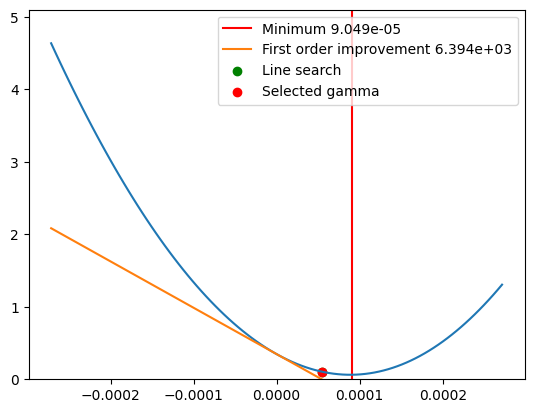

In [15]:
step()

Loss: 1.054e-01
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
Min: -0.5791396498680115, Max: 0.4797440767288208
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)
Min: -14.992019653320312, Max: 56.301029205322266


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)

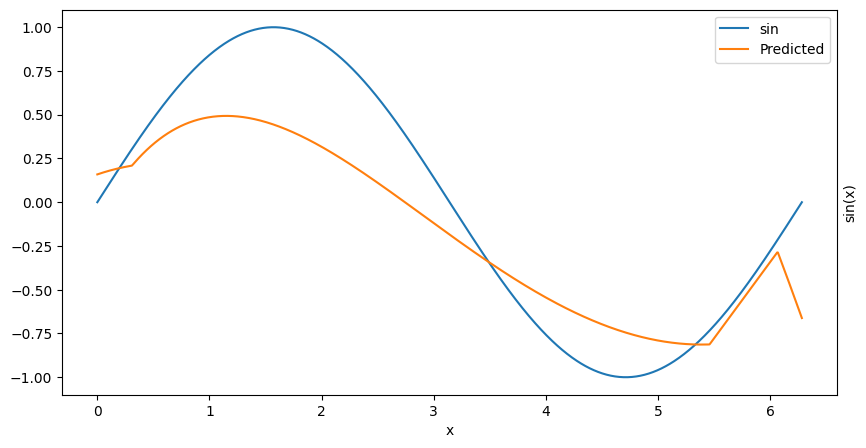

In [16]:
info()

Initial loss: 1.054e-01
Layer 0 update: 990.09521484375
Layer 0 parameter improvement: 990.09521484375
Layer 0 eigenvalues extension: None
Layer 1 update: 0.36208057403564453
Layer 1 parameter improvement: 0.36208057403564453
Layer 1 eigenvalues extension: None
Deleting layer 1
gamma: 1.065e-04 -> Loss: 6.308e-02
Selected gamma: 1.065e-04, new loss: 6.308e-02
Improvement: 4.234e-02, fo improvement: 1.054e-01


  0%|          | 0/100 [00:00<?, ?it/s]

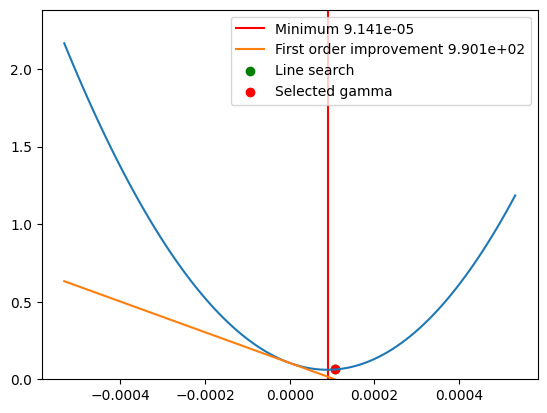

In [17]:
step()

Initial loss: 6.308e-02
Layer 0 update: 40.71656036376953
Layer 0 parameter improvement: 40.71656036376953
Layer 0 eigenvalues extension: None
Layer 1 update: 0.20148050785064697
Layer 1 parameter improvement: 0.20148050785064697
Layer 1 eigenvalues extension: None
Deleting layer 1
gamma: 1.549e-03 -> Loss: 5.451e-01
gamma: 7.746e-04 -> Loss: 1.686e-01
gamma: 3.873e-04 -> Loss: 8.168e-02
gamma: 1.936e-04 -> Loss: 6.380e-02
gamma: 9.682e-05 -> Loss: 6.129e-02
Selected gamma: 9.682e-05, new loss: 6.129e-02
Improvement: 1.789e-03, fo improvement: 3.942e-03


  0%|          | 0/100 [00:00<?, ?it/s]

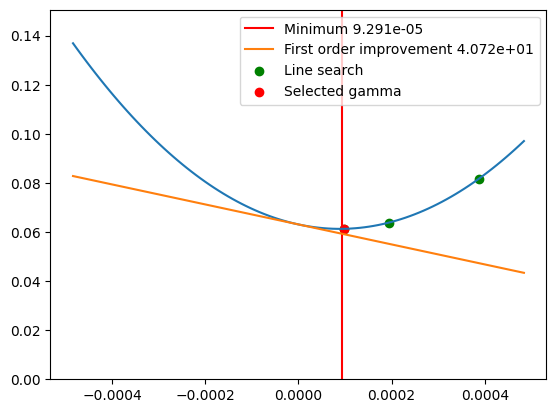

In [18]:
step()

Loss: 6.129e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
Min: -0.5791258215904236, Max: 0.4799354374408722
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)
Min: -14.992019653320312, Max: 56.301029205322266


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)

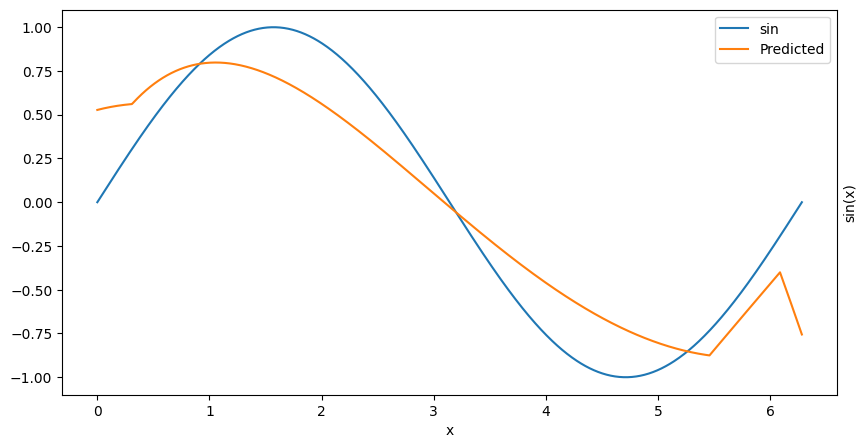

In [19]:
info()

Initial loss: 6.129e-02
Layer 0 update: 1.2565666437149048
Layer 0 parameter improvement: 1.2565666437149048
Layer 0 eigenvalues extension: None
Layer 1 update: 0.19372892379760742
Layer 1 parameter improvement: 0.19372892379760742
Layer 1 eigenvalues extension: None
Deleting layer 1
gamma: 4.877e-02 -> Loss: 1.128e+01
gamma: 2.439e-02 -> Loss: 2.824e+00
gamma: 1.219e-02 -> Loss: 7.409e-01
gamma: 6.097e-03 -> Loss: 2.269e-01
gamma: 3.048e-03 -> Loss: 1.007e-01
gamma: 1.524e-03 -> Loss: 7.018e-02
gamma: 7.621e-04 -> Loss: 6.303e-02
gamma: 3.810e-04 -> Loss: 6.148e-02
gamma: 1.905e-04 -> Loss: 6.122e-02
Selected gamma: 1.905e-04, new loss: 6.122e-02
Improvement: 7.065e-05, fo improvement: 2.394e-04


  0%|          | 0/100 [00:00<?, ?it/s]

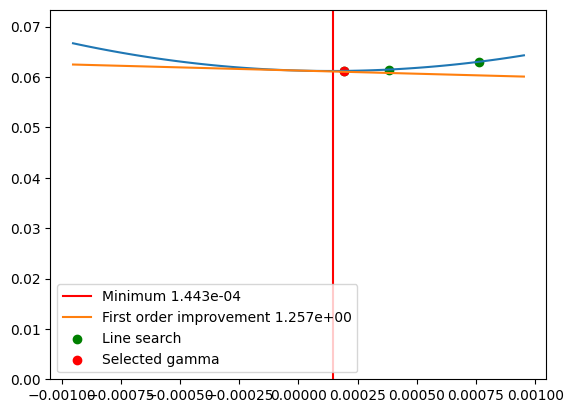

In [20]:
step()

Initial loss: 6.122e-02
Layer 0 update: 2.482269763946533
Layer 0 parameter improvement: 2.482269763946533
Layer 0 eigenvalues extension: None
Layer 1 update: 0.1924634724855423
Layer 1 parameter improvement: 0.1924634724855423
Layer 1 eigenvalues extension: None
Deleting layer 1
gamma: 2.466e-02 -> Loss: 8.815e+00
gamma: 1.233e-02 -> Loss: 2.274e+00
gamma: 6.165e-03 -> Loss: 6.064e-01
gamma: 3.083e-03 -> Loss: 1.923e-01
gamma: 1.541e-03 -> Loss: 9.191e-02
gamma: 7.707e-04 -> Loss: 6.791e-02
gamma: 3.853e-04 -> Loss: 6.241e-02
gamma: 1.927e-04 -> Loss: 6.127e-02
gamma: 9.633e-05 -> Loss: 6.111e-02
Selected gamma: 9.633e-05, new loss: 6.111e-02
Improvement: 1.051e-04, fo improvement: 2.391e-04


  0%|          | 0/100 [00:00<?, ?it/s]

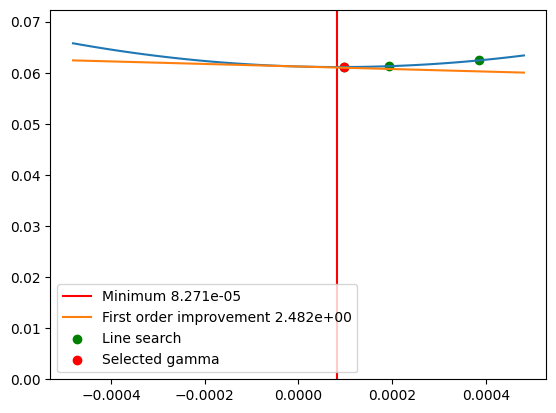

In [21]:
step()

Loss: 6.111e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
Min: -0.579138457775116, Max: 0.4798868000507355
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)
Min: -14.992019653320312, Max: 56.301029205322266


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)

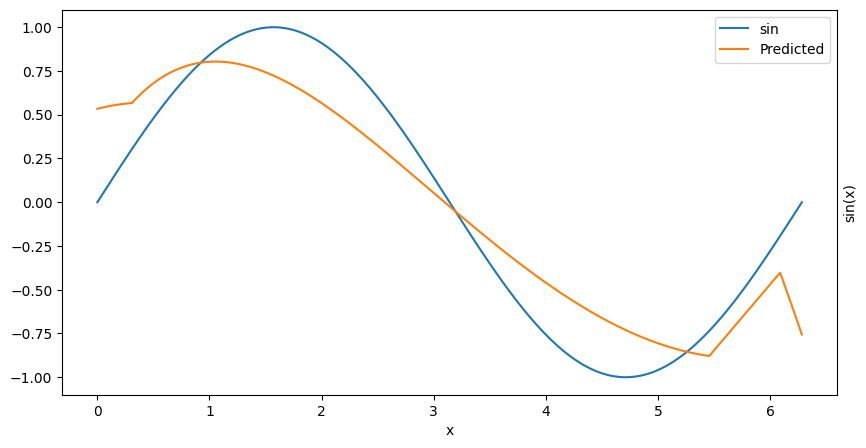

In [22]:
info()

In [23]:
for _ in range(10):
    step(show=False)

Initial loss: 6.111e-02
Selected gamma: 2.256e-04, new loss: 6.108e-02
Improvement: 3.532e-05, fo improvement: 2.387e-04
Initial loss: 6.108e-02
Selected gamma: 1.158e-04, new loss: 6.099e-02
Improvement: 8.489e-05, fo improvement: 4.772e-04
Initial loss: 6.099e-02
Selected gamma: 6.806e-05, new loss: 6.086e-02
Improvement: 1.258e-04, fo improvement: 2.382e-04
Initial loss: 6.086e-02
Selected gamma: 7.799e-04, new loss: 6.063e-02
Improvement: 2.368e-04, fo improvement: 4.755e-04
Initial loss: 6.063e-02
Selected gamma: 6.612e-05, new loss: 6.039e-02
Improvement: 2.345e-04, fo improvement: 4.737e-04
Initial loss: 6.039e-02
Selected gamma: 7.830e-04, new loss: 6.022e-02
Improvement: 1.738e-04, fo improvement: 4.718e-04
Initial loss: 6.022e-02
Selected gamma: 1.067e-04, new loss: 6.006e-02
Improvement: 1.615e-04, fo improvement: 9.409e-04
Initial loss: 6.006e-02
Selected gamma: 8.767e-05, new loss: 5.990e-02
Improvement: 1.626e-04, fo improvement: 4.692e-04
Initial loss: 5.990e-02
Selected

Loss: 5.975e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
Min: -0.5792499780654907, Max: 0.479442834854126
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)
Min: -14.992019653320312, Max: 56.301029205322266


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)

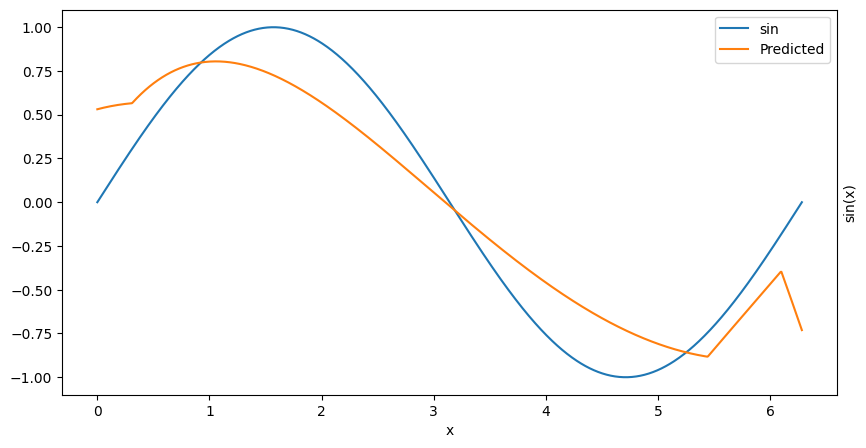

In [24]:
info()

Initial loss: 5.975e-02
Layer 0 update: 0.7542245984077454
Layer 0 parameter improvement: 0.7542245984077454
Layer 0 eigenvalues extension: None
Deleting layer 0
Layer 1 update: 0.19547200202941895
Layer 1 parameter improvement: 0.19547200202941895
Layer 1 eigenvalues extension: None
gamma: 3.057e-01 -> Loss: 1.867e-02
Selected gamma: 3.057e-01, new loss: 1.867e-02
Improvement: 4.108e-02, fo improvement: 5.975e-02


  0%|          | 0/100 [00:00<?, ?it/s]

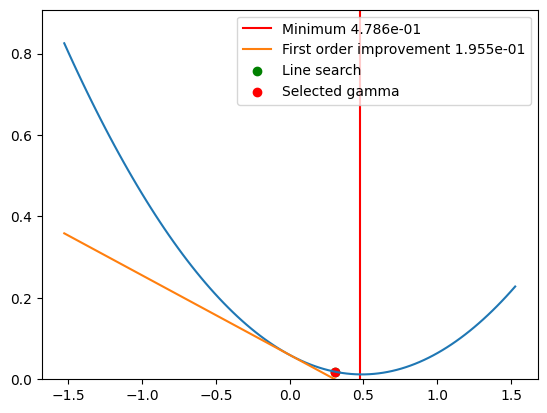

In [25]:
step(selected_layer=1)

Loss: 1.867e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
Min: -0.5792499780654907, Max: 0.479442834854126
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)
Min: -25.312850952148438, Max: 102.03551483154297


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)

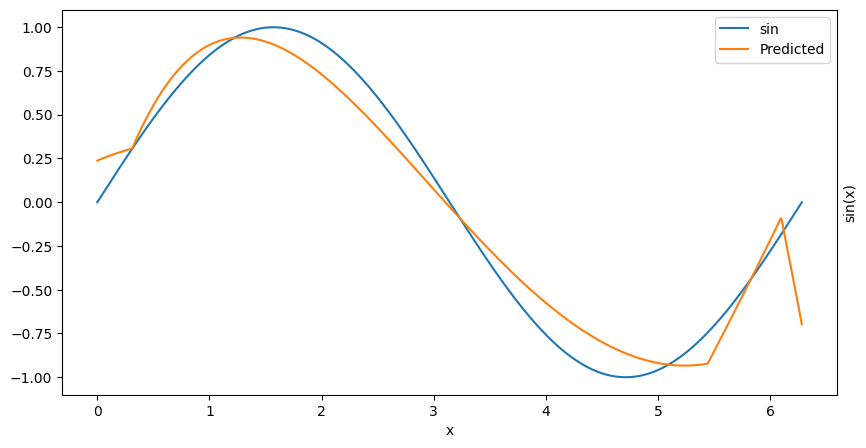

In [26]:
info()

Initial loss: 1.867e-02
Layer 0 update: 0.6999372839927673
Layer 0 parameter improvement: 0.6999372839927673
Layer 0 eigenvalues extension: None
Layer 1 update: 0.027507111430168152
Layer 1 parameter improvement: 0.027507111430168152
Layer 1 eigenvalues extension: None
Deleting layer 1
gamma: 2.668e-02 -> Loss: 7.435e+00
gamma: 1.334e-02 -> Loss: 1.865e+00
gamma: 6.670e-03 -> Loss: 4.670e-01
gamma: 3.335e-03 -> Loss: 1.276e-01
gamma: 1.668e-03 -> Loss: 4.506e-02
gamma: 8.338e-04 -> Loss: 2.495e-02
gamma: 4.169e-04 -> Loss: 2.009e-02
gamma: 2.084e-04 -> Loss: 1.896e-02
gamma: 1.042e-04 -> Loss: 1.871e-02
gamma: 5.211e-05 -> Loss: 1.866e-02
Selected gamma: 5.211e-05, new loss: 1.866e-02
Improvement: 9.783e-06, fo improvement: 3.647e-05


  0%|          | 0/100 [00:00<?, ?it/s]

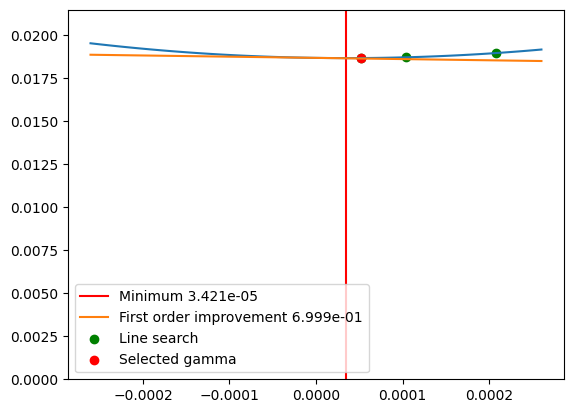

In [27]:
step()

Initial loss: 1.866e-02
Layer 0 update: 1.4002584218978882
Layer 0 parameter improvement: 1.4002584218978882
Layer 0 eigenvalues extension: None
Deleting layer 0
Layer 1 update: 0.02719402313232422
Layer 1 parameter improvement: 0.02719402313232422
Layer 1 eigenvalues extension: None
gamma: 6.864e-01 -> Loss: 1.281e-02
Selected gamma: 6.864e-01, new loss: 1.281e-02
Improvement: 5.851e-03, fo improvement: 1.866e-02


  0%|          | 0/100 [00:00<?, ?it/s]

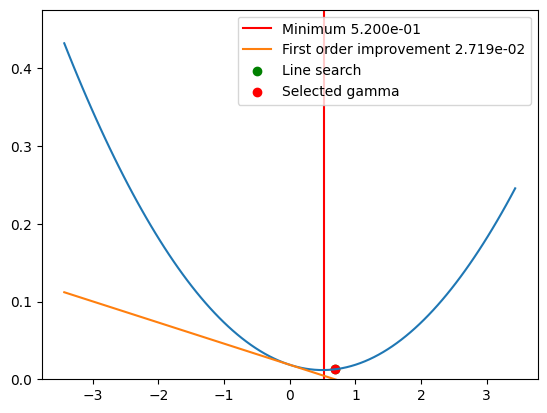

In [28]:
step(selected_layer=1)

Loss: 1.281e-02
LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
Min: -0.5792522430419922, Max: 0.4794358015060425
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)
Min: -33.651790618896484, Max: 138.26840209960938


LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=5, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=5, out_features=1, use_bias=True)

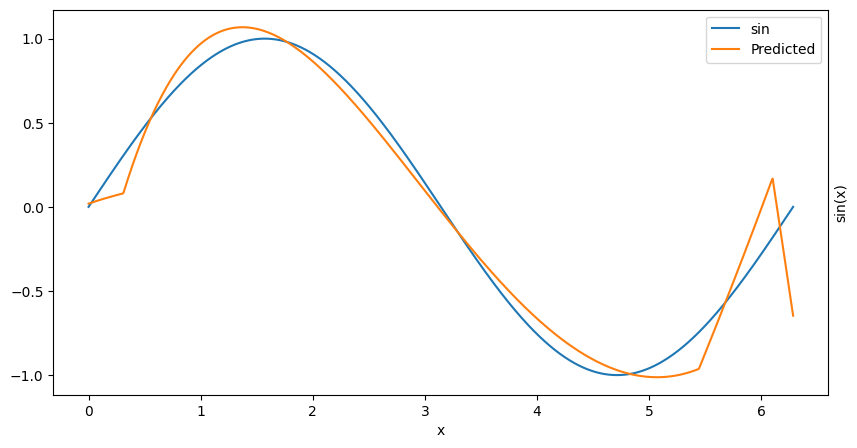

In [29]:
info()

# Fixed size MLP

In [22]:
nb_epoch = 100
batch_size = 1_000
nb_sample = 1_000

In [23]:
hidden_size = 1
seed = torch.randint(0, 1000, (1,)).item()
print(f"Seed: {seed}")
torch.manual_seed(seed)
l1 = nn.Linear(1, hidden_size, device=DEVICE)
l2 = nn.Linear(hidden_size, 1, device=DEVICE)
model = nn.Sequential(l1, nn.ReLU(), l2)


Seed: 44


In [88]:
l1.weight.data = torch.ones_like(l1.weight.data)
# a = np.pi / 4
# b = 1.
i = np.pi
j = 0
a_1 = -3 / np.pi ** 2
a_2 = -3 / np.pi ** 2

l1.bias.data = -torch.tensor([0, i], device=DEVICE)
l2.weight.data = torch.tensor([[a_1, a_2 - a_1]], device=DEVICE)
l2.bias.data = torch.tensor([j - a_1 * i], device=DEVICE)

In [18]:
l1.weight.data = torch.ones_like(l1.weight.data)
# a = np.pi / 4
# b = 1.
c = 0.651259030623100
a = -0.378951509815716
i = 1.636

l1.bias.data = -torch.tensor([i], device=DEVICE)
l2.weight.data = torch.tensor([[a]], device=DEVICE)
l2.bias.data = torch.tensor([c], device=DEVICE)

Initial error: 1.59e-01


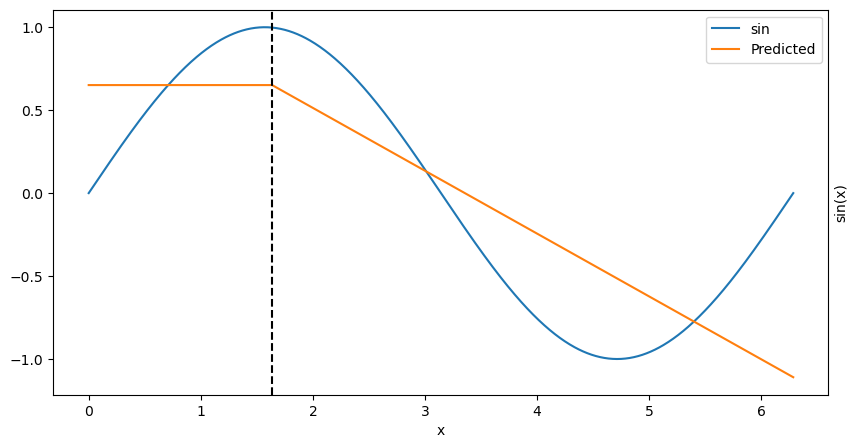

In [19]:
l2_err = evaluate_model(model, SinDataloader(nb_sample=nb_sample, batch_size=batch_size), AxisMSELoss())[0]
print(f"Initial error: {l2_err:.2e}")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt_model(model, ax)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


res = train(model=model, 
            train_dataloader=SinDataloader(batch_size=batch_size, nb_sample=nb_sample), 
            nb_epoch=10, 
            optimizer=optimizer,
            show=True)[0]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=5.082e-01, accuracy=0.00	 
Epoch 1:	 Train: loss=5.002e-01, accuracy=0.00	 
Epoch 2:	 Train: loss=5.002e-01, accuracy=0.00	 
Epoch 3:	 Train: loss=5.002e-01, accuracy=0.00	 
Epoch 4:	 Train: loss=5.002e-01, accuracy=0.00	 
Epoch 5:	 Train: loss=5.002e-01, accuracy=0.00	 
Epoch 6:	 Train: loss=5.002e-01, accuracy=0.00	 
Epoch 7:	 Train: loss=5.002e-01, accuracy=0.00	 
Epoch 8:	 Train: loss=5.002e-01, accuracy=0.00	 
Epoch 9:	 Train: loss=5.002e-01, accuracy=0.00	 


Initial error: 5.00e-01


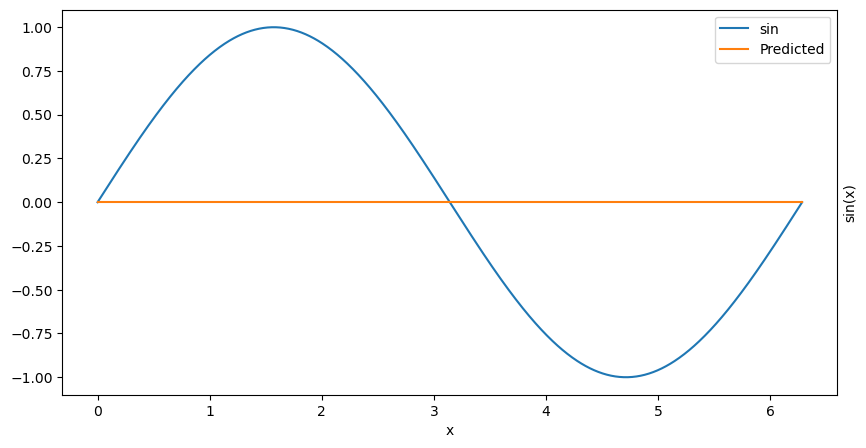

In [25]:
l2_err = evaluate_model(model, SinDataloader(nb_sample=nb_sample, batch_size=batch_size), AxisMSELoss())[0]
print(f"Initial error: {l2_err:.2e}")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt_model(model, ax)

Initial error: 1.59e-01


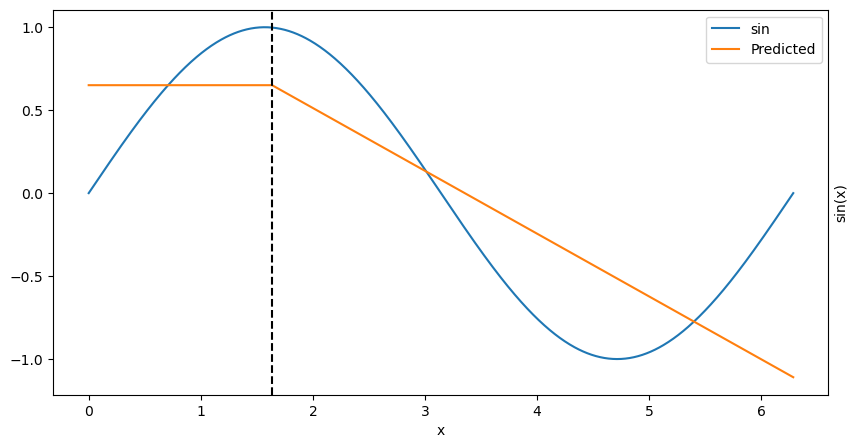

In [ ]:
l2_err = evaluate_model(model, SinDataloader(nb_sample=nb_sample, batch_size=batch_size), AxisMSELoss())[0]
print(f"Initial error: {l2_err:.2e}")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt_model(model, ax)

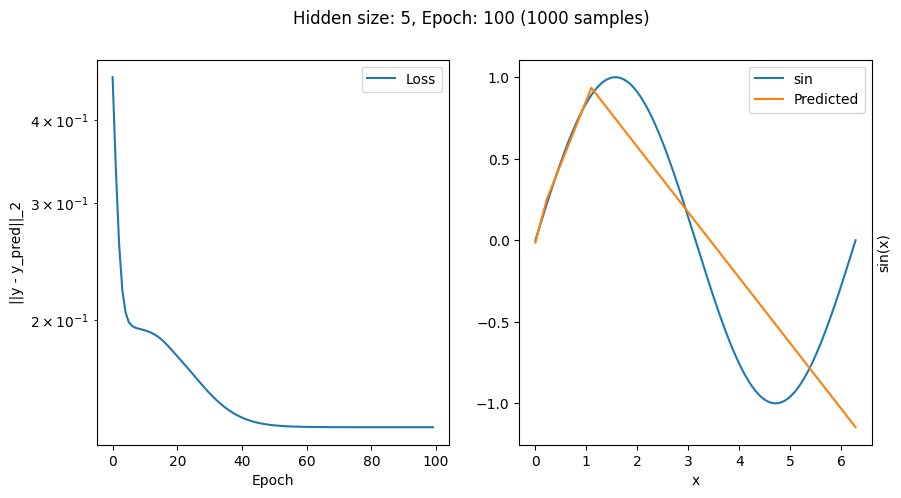

In [55]:
# plot the loss and the model on [0, 1]
# plt.title(f"Hidden size: {hidden_size}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# put a title on the figure
fig.suptitle(f"Hidden size: {hidden_size}, Epoch: {nb_epoch} ({nb_sample} samples)")

ax[0].plot(res, label="Loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("||y - y_pred||_2")
ax[0].set_yscale("log")

x = torch.linspace(0, 2 * np.pi, 1000, device=DEVICE).view(-1, 1)
y = torch.sin(x)
y_pred = model(x)
ax[1].plot(x.cpu().numpy(), y.cpu().numpy(), label="sin")
ax[1].plot(x.cpu().numpy(), y_pred.cpu().detach().numpy(), label="Predicted")
ax[1].legend()
ax[1].set_xlabel("x")
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel("sin(x)")
plt.show()

In [38]:
hidden_size = 100
model = GrowingMLP(1, 1, hidden_size, 2, activation=nn.SELU())
model

LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=100, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=100, out_features=100, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=100, out_features=1, use_bias=True)

In [39]:
res = train(model=model, 
            train_dataloader=SinDataloader(batch_size=batch_size, nb_sample=nb_sample), 
            nb_epoch=nb_epoch, 
            optimizer=torch.optim.SGD(model.parameters(), lr=1e-3), 
            show=True)[0]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=2.962e-01, accuracy=0.00	 
Epoch 10:	 Train: loss=1.196e-01, accuracy=0.00	 
Epoch 20:	 Train: loss=8.002e-02, accuracy=0.00	 
Epoch 30:	 Train: loss=4.887e-02, accuracy=0.00	 
Epoch 40:	 Train: loss=2.894e-02, accuracy=0.00	 
Epoch 50:	 Train: loss=1.622e-02, accuracy=0.00	 
Epoch 60:	 Train: loss=9.520e-03, accuracy=0.00	 
Epoch 70:	 Train: loss=5.883e-03, accuracy=0.00	 
Epoch 80:	 Train: loss=3.737e-03, accuracy=0.00	 
Epoch 90:	 Train: loss=2.476e-03, accuracy=0.00	 


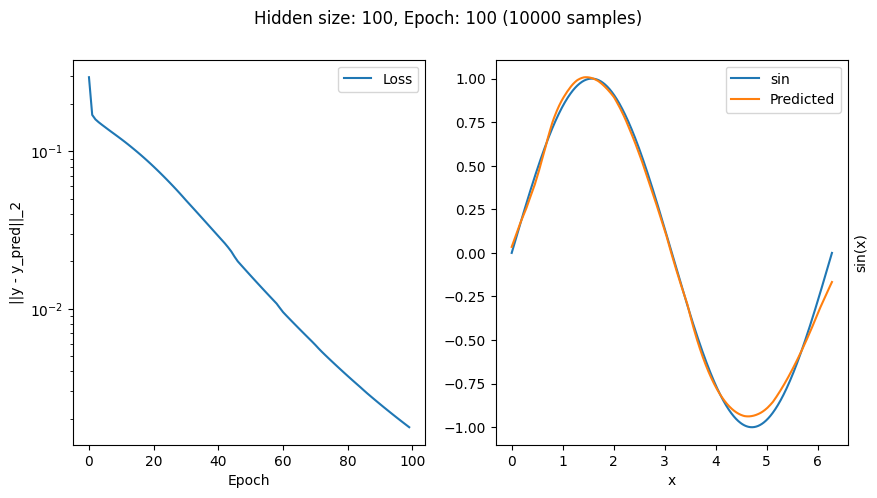

In [43]:
# plot the loss and the model on [0, 1]
# plt.title(f"Hidden size: {hidden_size}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# put a title on the figure
fig.suptitle(f"Hidden size: {hidden_size}, Epoch: {nb_epoch} ({nb_samples} samples)")

ax[0].plot(res, label="Loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("||y - y_pred||_2")
ax[0].set_yscale("log")

x = torch.linspace(0, 2 * np.pi, 1000, device=DEVICE).view(-1, 1)
y = torch.sin(x)
y_pred = model(x)
ax[1].plot(x.cpu().numpy(), y.cpu().numpy(), label="sin")
ax[1].plot(x.cpu().numpy(), y_pred.cpu().detach().numpy(), label="Predicted")
ax[1].legend()
ax[1].set_xlabel("x")
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel("sin(x)")
plt.show()

In [45]:
hidden_size = 10
model = GrowingMLP(1, 1, hidden_size, 2, activation=nn.SELU())
model

LinearGrowingModule(LinearGrowingModule(Layer 0))(in_features=1, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 1))(in_features=10, out_features=10, use_bias=True)
LinearGrowingModule(LinearGrowingModule(Layer 2))(in_features=10, out_features=1, use_bias=True)

In [46]:
res = train(model=model, 
            train_dataloader=SinDataloader(batch_size=batch_size, nb_sample=nb_sample), 
            nb_epoch=nb_epoch, 
            optimizer=torch.optim.SGD(model.parameters(), lr=1e-3), 
            show=True)[0]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=5.449e-01, accuracy=0.00	 
Epoch 10:	 Train: loss=1.826e-01, accuracy=0.00	 
Epoch 20:	 Train: loss=1.726e-01, accuracy=0.00	 
Epoch 30:	 Train: loss=1.631e-01, accuracy=0.00	 
Epoch 40:	 Train: loss=1.537e-01, accuracy=0.00	 
Epoch 50:	 Train: loss=1.454e-01, accuracy=0.00	 
Epoch 60:	 Train: loss=1.383e-01, accuracy=0.00	 
Epoch 70:	 Train: loss=1.314e-01, accuracy=0.00	 
Epoch 80:	 Train: loss=1.240e-01, accuracy=0.00	 
Epoch 90:	 Train: loss=1.162e-01, accuracy=0.00	 


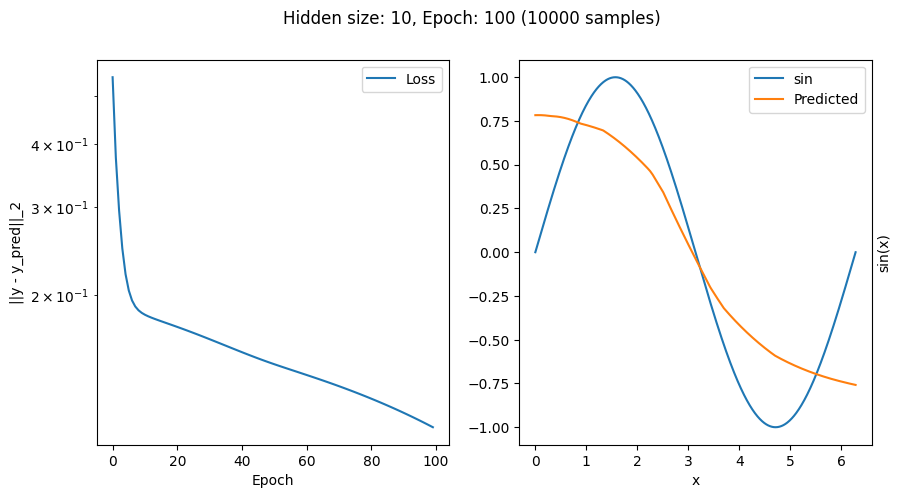

In [47]:
# plot the loss and the model on [0, 1]
# plt.title(f"Hidden size: {hidden_size}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# put a title on the figure
fig.suptitle(f"Hidden size: {hidden_size}, Epoch: {nb_epoch} ({nb_samples} samples)")

ax[0].plot(res, label="Loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("||y - y_pred||_2")
ax[0].set_yscale("log")

x = torch.linspace(0, 2 * np.pi, 1000, device=DEVICE).view(-1, 1)
y = torch.sin(x)
y_pred = model(x)
ax[1].plot(x.cpu().numpy(), y.cpu().numpy(), label="sin")
ax[1].plot(x.cpu().numpy(), y_pred.cpu().detach().numpy(), label="Predicted")
ax[1].legend()
ax[1].set_xlabel("x")
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel("sin(x)")
plt.show()

NameError: name 'res' is not defined

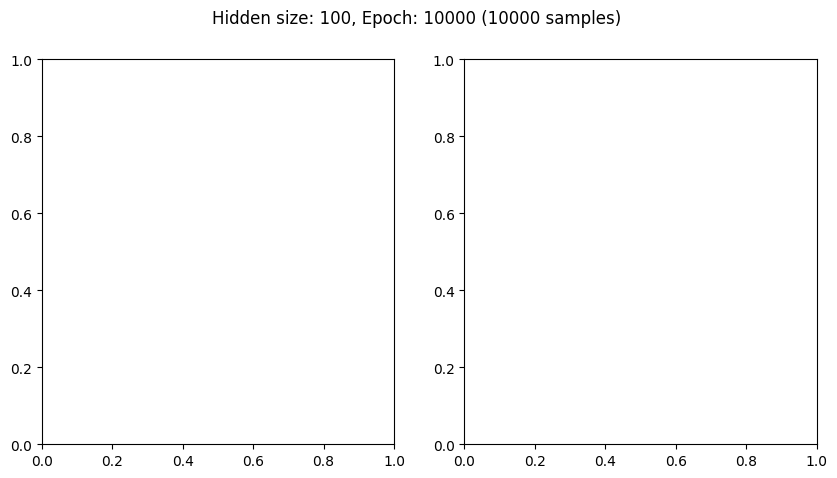

In [32]:
# plot the loss and the model on [0, 1]
# plt.title(f"Hidden size: {hidden_size}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# put a title on the figure
fig.suptitle(f"Hidden size: {hidden_size}, Epoch: {nb_epoch} ({nb_samples} samples)")

ax[0].plot(res, label="Loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("||y - y_pred||_2")
ax[0].set_yscale("log")

x = torch.linspace(0, 2 * np.pi, 1000, device=DEVICE).view(-1, 1)
y = torch.sin(x)
y_pred = model(x)
ax[1].plot(x.cpu().numpy(), y.cpu().numpy(), label="sin")
ax[1].plot(x.cpu().numpy(), y_pred.cpu().detach().numpy(), label="Predicted")
ax[1].legend()
ax[1].set_xlabel("x")
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel("sin(x)")
plt.show()